In [1]:
%pwd

'/content'

In [2]:
%cd /content/drive/MyDrive/contest3/

/content/drive/MyDrive/contest3


In [3]:
%ls -l

total 137186
-rw------- 1 root root   479115 Nov 27 13:13 baseline-deeplabv3-crack-segmentation.ipynb
-rw------- 1 root root 72055804 Nov 23 00:03 copy-of-crack-segmentation-cnu.zip
-rw------- 1 root root   217172 Nov 28 02:47 crack_detection.ipynb
drwx------ 2 root root     4096 Nov 27 11:14 data/
-rw------- 1 root root 67708808 Nov 22 05:11 DeepCrack.zip
drwx------ 2 root root     4096 Nov 27 11:57 DeepSegmentor/
drwx------ 2 root root     4096 Nov 27 11:25 kaggle_dataset/
drwx------ 2 root root     4096 Nov 27 13:28 model_checkpoint/
-rw------- 1 root root      331 Nov 27 10:28 slient_night_holy_night.txt


In [ ]:
%cd /content/drive/MyDrive/contest3/kaggle_dataset/train_img/
!find . -type f | wc -l # count files
%cd /content/drive/MyDrive/contest3

/content/drive/MyDrive/contest3/kaggle_dataset/train_img
300
/content/drive/MyDrive/contest3


In [ ]:
!unzip DeepCrack.zip -d './data/'

In [ ]:
%cd ./data

/content/drive/MyDrive/contest3/data


In [ ]:
!mkdir kaggle_dataset

In [ ]:
!kaggle competitions download -c copy-of-crack-segmentation-cnu

 99% 68.0M/68.7M [00:03<00:00, 35.2MB/s]
100% 68.7M/68.7M [00:03<00:00, 21.4MB/s]


In [ ]:
!unzip copy-of-crack-segmentation-cnu.zip -d './kaggle_dataset/'

In [ ]:
!git clone https://github.com/yhlleo/DeepSegmentor.git

Cloning into 'DeepSegmentor'...
remote: Enumerating objects: 1627, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 1627 (delta 12), reused 16 (delta 10), pack-reused 1605
Receiving objects: 100% (1627/1627), 44.98 MiB | 10.93 MiB/s, done.
Resolving deltas: 100% (866/866), done.
Updating files: 100% (216/216), done.


In [ ]:
!ls -l

total 136507
-rw-------  1 root root 72055804 Nov 23 00:03 copy-of-crack-segmentation-cnu.zip
-rw-------  1 root root     5029 Nov 27 11:56 crack_detection.ipynb
drwx------  6 root root     4096 Nov 27 11:14 data
-rw-------  1 root root 67708808 Nov 22 05:11 DeepCrack.zip
drwx------ 14 root root     4096 Nov 27 11:57 DeepSegmentor
drwx------  5 root root     4096 Nov 27 11:35 kaggle_dataset
-rw-------  1 root root      331 Nov 27 10:28 slient_night_holy_night.txt


In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split

from glob import glob
import torch
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision
import random, gc

seed=42

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"current device : {device}")

current device : cuda


In [6]:
CFG = {
    'EPOCHS' : 30,
    'LEARNING_RATE' : 1e-4,
    'NUM_CLASSES' : 1,
    'BATCH_SIZE' : 4,
    'SEED' : 42,
    'IMAGE_SIZE' : 256,
    'PATH' : os.path.join('/content/drive/MyDrive/contest3/model_checkpoint/', 'segment_model.pth')
}

In [7]:
def init_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  np.random.seed(seed)

  random.seed(seed)

  gc.collect()
  torch.cuda.empty_cache()

init_seed(CFG['SEED'])

In [8]:
base_path = '/content/drive/MyDrive/contest3/kaggle_dataset/'
path_to_images = os.path.join(base_path, 'train_img')
path_to_masks = os.path.join(base_path, 'train_lab')

image_paths = sorted(glob(path_to_images + '/*.jpg'))
mask_paths = sorted(glob(path_to_masks + '/*.png'))

In [9]:
test_files = pd.read_csv(os.path.join('/content/drive/MyDrive/contest3/kaggle_dataset/', 'test_files.csv'))
test_files

,ID,label
0,11194.jpg,0
1,11270-2.jpg,0
2,11296-6.jpg,0
3,11231-9.jpg,0
4,11249-6.jpg,0
...,...,...
232,IMG_6542-7.jpg,0
233,11295.jpg,0
234,11169-2.jpg,0
235,11247-8.jpg,0


In [10]:
print("img file counts : ", len(image_paths))
print("mask file counts : ", len(mask_paths))

img file counts :  300
mask file counts :  300


In [11]:
print("test file counts : ", len(test_files))

test file counts :  237


In [12]:
train_df = pd.DataFrame({'ID' : image_paths, 'label' : mask_paths})
train_df.head(5)

,ID,label
0,/content/drive/MyDrive/contest3/kaggle_dataset...,/content/drive/MyDrive/contest3/kaggle_dataset...
1,/content/drive/MyDrive/contest3/kaggle_dataset...,/content/drive/MyDrive/contest3/kaggle_dataset...
2,/content/drive/MyDrive/contest3/kaggle_dataset...,/content/drive/MyDrive/contest3/kaggle_dataset...
3,/content/drive/MyDrive/contest3/kaggle_dataset...,/content/drive/MyDrive/contest3/kaggle_dataset...
4,/content/drive/MyDrive/contest3/kaggle_dataset...,/content/drive/MyDrive/contest3/kaggle_dataset...


In [13]:
test_files['ID'] = base_path + '/test_img/' + test_files['ID']
test_files.head(5)

,ID,label
0,/content/drive/MyDrive/contest3/kaggle_dataset...,0
1,/content/drive/MyDrive/contest3/kaggle_dataset...,0
2,/content/drive/MyDrive/contest3/kaggle_dataset...,0
3,/content/drive/MyDrive/contest3/kaggle_dataset...,0
4,/content/drive/MyDrive/contest3/kaggle_dataset...,0


In [14]:
train, valid = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=seed)

print(f"splited train size : {len(train)}, \
 validation size: {len(valid)}, test size : {len(test_files)}")


splited train size : 270,  validation size: 30, test size : 237


In [15]:
train_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    T.ToTensor()
])

In [16]:
class CrackDataset(Dataset):
  def __init__(self, dataset, train_mode=True, transforms=train_transforms):
    self.dataset = dataset.reset_index(drop=True)
    self.transforms = transforms
    self.train_mode = train_mode

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    row = self.dataset.loc[idx].squeeze()

    if self.train_mode:
      image_path = row['ID']
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image_tensor = self.transforms(image).float()

      mask_path = row['label']
      mask = cv2.imread(mask_path)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      mask = cv2.resize(mask, (CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']))

      _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
      mask_tensor = torch.as_tensor(mask[None], dtype=torch.float32)

      return image_tensor, mask_tensor

    else:
      image_path = row['ID']
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image_tensor = self.transforms(image).float()

      return image_tensor

  def collate_fn(self, batch):
    images, masks = tuple(zip(*batch))

    # pytorch None indexing specifies one dimension (not possible in python syntax..)
    images = [img[None] for img in images]
    masks = [msk[None] for msk in masks]

    images, masks = [torch.cat(i).to(device) for i in [images, masks]]
    return images, masks

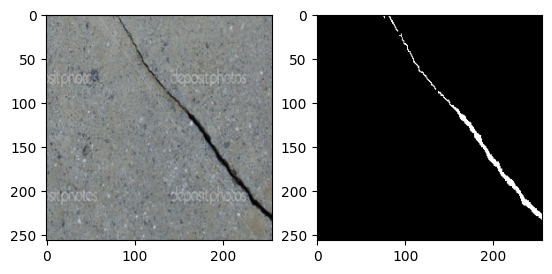

In [17]:
train_data = CrackDataset(train)

plt.subplot(121)
# channel, height, width -> height, width, channel (transpose(1, 2, 0))
# train[1][0] -> train image, train[1][1] -> train mask(label)
# train[idx] -> train image index
plt.imshow(train_data[15][0].cpu().detach().numpy().transpose(1, 2, 0))
plt.subplot(122)
plt.imshow(train_data[15][1].cpu().detach().numpy().transpose(1, 2, 0), cmap='gray')

In [18]:
@torch.no_grad()
def validate_test_image(model, dataset):
  idx = np.random.randint(len(dataset))
  dataset = dataset.reset_index(drop=True)
  row = dataset.loc[idx].squeeze()

  image = cv2.imread(row['ID'])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_tensor = train_transforms(image).unsqueeze(0).to(device)

  mask = cv2.imread(row['label'])
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = cv2.resize(mask, (CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']))
  _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

  model.eval()
  output = model(image_tensor)
  output = output['out'][0].cpu().detach().numpy().transpose(1, 2, 0)

  plt.figure(figsize=(8, 4))
  plt.subplot(131)
  plt.title('Original image')
  plt.imshow(image)

  plt.subplot(132)
  plt.title('Original mask')
  plt.imshow(mask, cmap='gray')

  plt.subplot(133)
  plt.title('Predicted mask')
  plt.imshow(output, cmap='gray')

  plt.tight_layout()
  plt.show()
  plt.pause(0.001)


In [19]:
train_dataset = CrackDataset(train)
valid_dataset = CrackDataset(valid)
test_dataset = CrackDataset(test_files, train_mode=False)

train_dataloader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True,
                              collate_fn = train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False,
                              collate_fn=valid_dataset.collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

In [20]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

def get_model(output_channels=1, unfreeze=True):
  model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True, progress=False)

  for param in model.parameters():
    param.requires_grad = unfreeze

  model.classifier = DeepLabHead(2048, output_channels)
  return model.to(device)

model = get_model() # set output_channels = 3 if label mask is color channel

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [21]:
class EarlyStopping:
  def __init__(self, patience=5, min_delta=0, path=CFG['PATH']):
    self.path = path
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = np.inf
    self.early_stop = False

  def __call__(self, val_loss, model=None):
    if self.best_loss - val_loss > self.min_delta:
      torch.save(model, self.path)
      print(f'Model saved to : {self.path}')
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
      if self.counter >= self.patience:
        print('INFO: Early stopping')
        self.early_stop = True


In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-6, factor=0.1)
early=EarlyStopping()

In [23]:
def train_one_batch(batch, model, criterion, optimizer):
  images, masks = batch
  optimizer.zero_grad()
  output = model(images)
  loss = criterion(output['out'], masks)
  loss.backward()
  optimizer.step()

  return loss.item()

@torch.no_grad()
def validate_one_batch(batch, model, criterion):
  images, masks = batch
  output = model(images)
  loss = criterion(output['out'], masks)
  return loss.item()

def validate_one_batch(batch, model):
  images, masks = batch
  output = model(images)
  loss = criterion(output['out'], masks)
  return loss.item()

In [24]:
train_losses, valid_losses = [], []
from sklearn.metrics import f1_score

for epoch in range(CFG['EPOCHS']):

  print(f'Epoch {epoch+1}/{CFG["EPOCHS"]}')
  epoch_train_losses, epoch_valid_losses = [], []

  model.train()
  for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
    batch_train_loss = train_one_batch(batch, model, criterion, optimizer)
    epoch_train_losses.append(batch_train_loss)

  epoch_train_loss = np.array(epoch_train_losses).mean()
  train_losses.append(epoch_train_loss)

  print(f"Train loss: {epoch_train_loss:.4f}.")

  model.eval()
  y_true, y_pred = [], []

  for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
    images, masks = batch
    output = model(images)
    batch_valid_loss = criterion(output['out'], masks)
    epoch_valid_losses.append(batch_valid_loss.item())

    y_true.append(masks.cpu().numpy())
    y_pred.append(output['out'].cpu().detach().numpy())

  epoch_valid_loss = np.array(epoch_valid_losses).mean()
  valid_losses.append(epoch_valid_loss)
  print(f'Valid loss: {epoch_valid_loss:.4f}.')
  print('-'*50)

  y_true = np.concatenate(y_true, axis=0)
  y_pred = np.concatenate(y_pred, axis=0)
  y_pred = np.where(y_pred > 127, 255, 0)

  y_true = y_true.reshape(-1) / 255
  y_pred = y_pred.reshape(-1) / 255

  validate_test_image(model, valid)
  print('Val F1 Score:', f1_score(y_pred, y_true))


  scheduler.step(epoch_valid_loss)
  early(epoch_valid_loss, model =model)
  if early.early_stop:
    print(f"Validation loss did not improve for {early.patience} epochs. Training stopped.")
    model.load_state_dict(torch.load(CFG['PATH']))
    break


Output hidden; open in https://colab.research.google.com to view.

In [25]:
y_pred = []
model = get_model()
model = torch.load(CFG['PATH'])
my_submission = pd.read_csv(os.path.join(base_path, 'test_files.csv'))

model.eval()
for path, images in tqdm(zip(my_submission['ID'], test_dataloader), total=len(test_dataloader)):
  output = model(images.to(device))['out'].cpu().detach().numpy()
  output = np.where(output.astype(np.float32) > 127, 255, 0) / 255
  output = output[0][0].reshape(-1, )
  img = list(map(int, output.tolist()))
  label = "".join(map(str, img))

  chunk_size = 8
  chunks = [label[i:i+chunk_size] for i in range(0, len(label), chunk_size)]

  for i in range(len(chunks)):
    y_pred.append([path+str(i), "2" + chunks[i]])


  0%|          | 0/237 [00:00<?, ?it/s]

In [26]:
submission = pd.DataFrame(y_pred, columns=['ID', 'label'])
submission['label'] = submission['label'].astype(int)
submission.to_csv('./results.csv', index=False)